In [1]:
import sys
import numpy as np
import pandas as pd
import copy
import random
import math
from scipy import stats
from scipy.stats import rankdata
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import metrics, preprocessing
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display
np.random.seed(1)

In [2]:
cols = ['age', 'workclass', 'fnlwgt', 'education', 'education.num', 'marital', 'occupation', 'relationship', 'race', 'gender', 'capgain', 'caploss', 'hours', 'country', 'income']
df_train = pd.read_csv('adult.data', names=cols, sep=",")
df_test = pd.read_csv('adult.test', names=cols, sep=",")

**One-hot encoding**

In [3]:
 def one_hot_encode(df):
    df.isin(['?']).sum(axis=0)

    # replace missing values (?) to nan and then drop the columns
    df['country'] = df['country'].replace('?',np.nan)
    df['workclass'] = df['workclass'].replace('?',np.nan)
    df['occupation'] = df['occupation'].replace('?',np.nan)

    # dropping the NaN rows now
    df.dropna(how='any',inplace=True)
    df['income'] = df['income'].map({'<=50K': 0, '>50K': 1}).astype(int)
    df = pd.concat([df, pd.get_dummies(df['gender'], prefix='gender')],axis=1)
    df = pd.concat([df, pd.get_dummies(df['race'], prefix='race')],axis=1)
    df = pd.concat([df, pd.get_dummies(df['marital'], prefix='marital')],axis=1)
    df = pd.concat([df, pd.get_dummies(df['workclass'], prefix='workclass')],axis=1)
    df = pd.concat([df, pd.get_dummies(df['relationship'], prefix='relationship')],axis=1)
    df = pd.concat([df, pd.get_dummies(df['occupation'], prefix='occupation')],axis=1)

    df = df.drop(columns=['workclass', 'gender', 'fnlwgt', 'education', 'occupation', \
                      'relationship', 'marital', 'race', 'country', 'capgain', \
                      'caploss'])
    return df

# one-hot encoding (for regression mdoels)
df_train = one_hot_encode(df_train)
df_test = one_hot_encode(df_test)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

**Protected, privileged**

In [4]:
# protected: 'gender_Female'=1
# privileged: 'gender_Male'=1

**Parametric Model**

In [5]:
X_train = df_train.drop(columns='income')
y_train = df_train['income']

X_test = df_test.drop(columns='income')
y_test = df_test['income']

# size=10000
# X_train = X_train[0:size]
# y_train = y_train[0:size]

# X_test = X_test[0:size]
# y_test = y_test[0:size]
X_train_orig = copy.deepcopy(X_train)
X_test_orig = copy.deepcopy(X_test)

# Scale data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

clf = LogisticRegression(random_state=0)

clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)
num_params = len(clf.coef_.transpose()) + 1 #weights and intercept
# clf.classes_, clf.coef_, clf.intercept_

**Compute statistical parity difference**

In [6]:
def computeFairness(y_pred, X_test): 
    protected_idx = X_test[X_test['gender_Female']==1].index
    numProtected = len(protected_idx)
    privileged_idx = X_test[X_test['gender_Male']==1].index
    numPrivileged = len(privileged_idx)
    
    p_protected = 0
    for i in range(len(protected_idx)):
        p_protected += y_pred[protected_idx[i]][1]
    p_protected /= len(protected_idx)
    
    p_privileged = 0
    for i in range(len(privileged_idx)):
        p_privileged += y_pred[privileged_idx[i]][1]
    p_privileged /= len(privileged_idx)
    
    spd = p_protected - p_privileged
    return spd

**Influence of points computed using ground truth**

In [7]:
def ground_truth_influence(X_train, y_train, X_test, X_test_orig):
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)
    spd_0 = computeFairness(y_pred, X_test_orig)

    delta_spd = []
    for i in range(len(X_train)):
        X_removed = np.delete(X_train, i, 0)
        y_removed = y_train.drop(index=i, inplace=False)
        clf.fit(X_removed, y_removed)
        y_pred = clf.predict_proba(X_test)
        delta_spd_i = computeFairness(y_pred, X_test_orig) - spd_0
        delta_spd.append(delta_spd_i)
    
    return delta_spd

# delta_spd = ground_truth_influence(X_train, y_train, X_test, X_test_orig)

# with open('delta_spd_ground_truth_v0.txt', 'w') as filehandle:
#     for listitem in delta_spd:
#         filehandle.write('%s\n' % listitem)

clf.fit(X_train, y_train)

LogisticRegression(random_state=0)

**Loss function** (Log loss for logistic regression)

In [8]:
def logistic_loss(y_true, y_pred):
    loss = 0
    for i in range(len(y_true)):
        loss += - y_true[i] * math.log(y_pred[i][1]) - (1 - y_true[i]) * math.log(y_pred[i][0])
    loss /= len(y_true)
    return loss

print(logistic_loss(y_test, y_pred))

0.360972684923813


**First-order derivative of loss function at z with respect to model parameters**

In [9]:
def del_L_del_theta_i(num_params, y_true, x, y_pred):
    del_L_del_theta = np.ones((num_params, 1)) * ((1 - y_true) * y_pred[1] - y_true * y_pred[0])
    for j in range(1, num_params):
            del_L_del_theta[j] *=  x[j-1]
    return del_L_del_theta
# value to be multiplied by a factor of 1/n

**Second-order partial derivative of loss function with respect to model parameters**

In [10]:
def hessian_one_point(num_params, x, y_pred):
    H = np.ones((num_params, num_params)) * (y_pred[0] * y_pred[1])
    for i in range(1, num_params):
        for j in range(i+1):
            if j == 0:
                H[i][j] *= x[i-1]
            else:
                H[i][j] *= x[i-1] * x[j-1] 
    i_lower = np.tril_indices(num_params, -1)
    H.T[i_lower] = H[i_lower]     
    return H
# value to be multiplied by a factor of 1/n

**First-order derivative of $P(y \mid \textbf{x})$ with respect to model parameters**

In [11]:
def del_f_del_theta_i(num_params, x, y_pred):
    del_f_del_theta = np.ones((num_params, 1)) * (y_pred[0] * y_pred[1])
    for j in range(1, num_params):
            del_f_del_theta[j] *=  x[j-1]
    return del_f_del_theta

**Computing $v=\nabla($Statistical parity difference$)$**

In [12]:
# Return v = del(SPD)/del(theta)
def del_spd_del_theta(num_params, X_test_orig, X_test):
    del_f_protected = np.zeros((num_params, 1))
    del_f_privileged = np.zeros((num_params, 1))
    numProtected = X_test_orig['gender_Female'].sum()
    numPrivileged = X_test_orig['gender_Male'].sum()
    for i in range(len(X_test)):
        y_pred = clf.predict_proba(np.reshape(X_test[i], (1, num_params-1)))
        del_f_i = del_f_del_theta_i(num_params, X_test[i], y_pred[0])
        if X_test_orig.iloc[i]['gender_Male'] == 1: #privileged
            del_f_privileged = np.add(del_f_privileged, del_f_i)
        elif X_test_orig.iloc[i]['gender_Female'] == 1:
            del_f_protected = np.add(del_f_protected, del_f_i)
    del_f_privileged /= numPrivileged
    del_f_protected /= numProtected
    v = np.subtract(del_f_protected, del_f_privileged)
    return v

v = del_spd_del_theta(num_params, X_test_orig, X_test)
print(v.transpose())

[[-0.07592556 -0.02845483 -0.00188227 -0.048868    0.18897018 -0.18897018
   0.00432292  0.00389831  0.02087455  0.00332219 -0.02144056  0.05088862
   0.01123877 -0.10314517  0.00858797  0.05175203  0.01726284  0.03296542
  -0.00357517  0.01094144  0.01323908 -0.0188173  -0.02027118  0.00537222
   0.00162495 -0.16729359  0.05124135  0.01690447  0.03085331  0.05147186
   0.14380155  0.04574062 -0.00243153 -0.04495888 -0.00261241 -0.00736998
   0.00239309 -0.00383049  0.02655014  0.00646609  0.0154396  -0.01892167
  -0.00983248  0.00367317 -0.02545955]]


**Stochastic estimation of Hessian vector product: $H_{\theta}^{-1}v = H_{\theta}^{-1}\nabla_{\theta}f(z, \theta) = v + [I - \nabla_{\theta}^2L(z_{s_j}, \theta^*)]H_{\theta}^{-1}v$**

In [13]:
# Uniformly sample t points from training data 
def hessian_vector_product(num_params, X_train, v):
    size = len(X_train)
    sample = random.sample(range(len(X_train)), size)

    hinv_v = copy.deepcopy(v)
    for idx in range(size):
        i = sample[idx]
        y_pred = clf.predict_proba(np.reshape(X_train[i], (1, num_params-1)))
        hessian_i = hessian_one_point(num_params, X_train[i], y_pred[0])/len(X_train)
        hinv_v = np.matmul(np.subtract(np.identity(num_params), hessian_i), hinv_v)
        hinv_v = np.add(hinv_v, v)
        
    return hinv_v

hinv_v = hessian_vector_product(num_params, X_train, v)
print(hinv_v.transpose())

[[-1669.50783872  -578.0200568    -41.7249153  -1111.80855373
   4725.2596424  -4725.2596424     95.33737998    90.93613294
    449.83851093    66.53821647  -464.76178432  1143.54962843
    277.74437239 -2226.85175179   173.26474858  1057.49371263
    372.4899619    790.32481556  -127.09184211   270.06431846
    273.13568747  -401.54667296  -423.08034473   119.99888671
     35.61366787 -3829.39500726  1039.73849439   397.48661057
    662.8271541   1204.98636748  3592.93462057  1051.99356347
    -77.35884291 -1002.09463415   -25.93530381  -160.03194603
     18.13560039  -110.07758384   594.41718317   149.96884882
    331.03054902  -441.62901671  -219.76976519    79.43155923
   -575.85826821]]


**Influence of points computed using Hessian vector product**

In [40]:
def hessian_vector_product_influence(num_params, X_train, y_train, hinv_v):
    infs = []
    clf.fit(X_train, y_train)
    for i in range(len(X_train)):
        y_pred = clf.predict_proba(np.reshape(X_train[i], (1, num_params-1)))
        del_L_del_theta = del_L_del_theta_i(num_params, y_train[i], X_train[i], y_pred[0])/len(X_train)
        inf = -np.dot(del_L_del_theta.transpose(), hinv_v)
        inf *= -1/len(X_train)
        infs.append(inf[0][0].tolist())
    return infs

infs = hessian_vector_product_influence(num_params, X_train, y_train, hinv_v) 

In [41]:
gt_spd = pd.read_csv('delta_spd_ground_truth_v0.txt', names=["Values"], sep=",")
gt_spd = gt_spd.values.tolist()
spdgt=[]
for i in range(len(gt_spd)):
    spdgt.append(gt_spd[i][0])
stats.spearmanr(spdgt, infs)[0]
# stats.pearsonr(gt_spd, infs)

0.9389496919771055

**Decision trees for ground truth vs. influence functions**

Ground truth decision tree
Influence functions decision tree


[Text(1953.0, 1359.0, 'age <= 1.604\nmse = 5.072\nsamples = 30162\nvalue = 0.0'),
 Text(976.5, 815.3999999999999, 'hours <= 3.72\nmse = 4.956\nsamples = 28080\nvalue = 0.028'),
 Text(488.25, 271.79999999999995, 'mse = 4.915\nsamples = 27957\nvalue = 0.034'),
 Text(1464.75, 271.79999999999995, 'mse = 12.307\nsamples = 123\nvalue = -1.384'),
 Text(2929.5, 815.3999999999999, 'relationship_Husband <= 0.176\nmse = 6.485\nsamples = 2082\nvalue = -0.377'),
 Text(2441.25, 271.79999999999995, 'mse = 2.639\nsamples = 906\nvalue = 0.244'),
 Text(3417.75, 271.79999999999995, 'mse = 8.922\nsamples = 1176\nvalue = -0.856')]

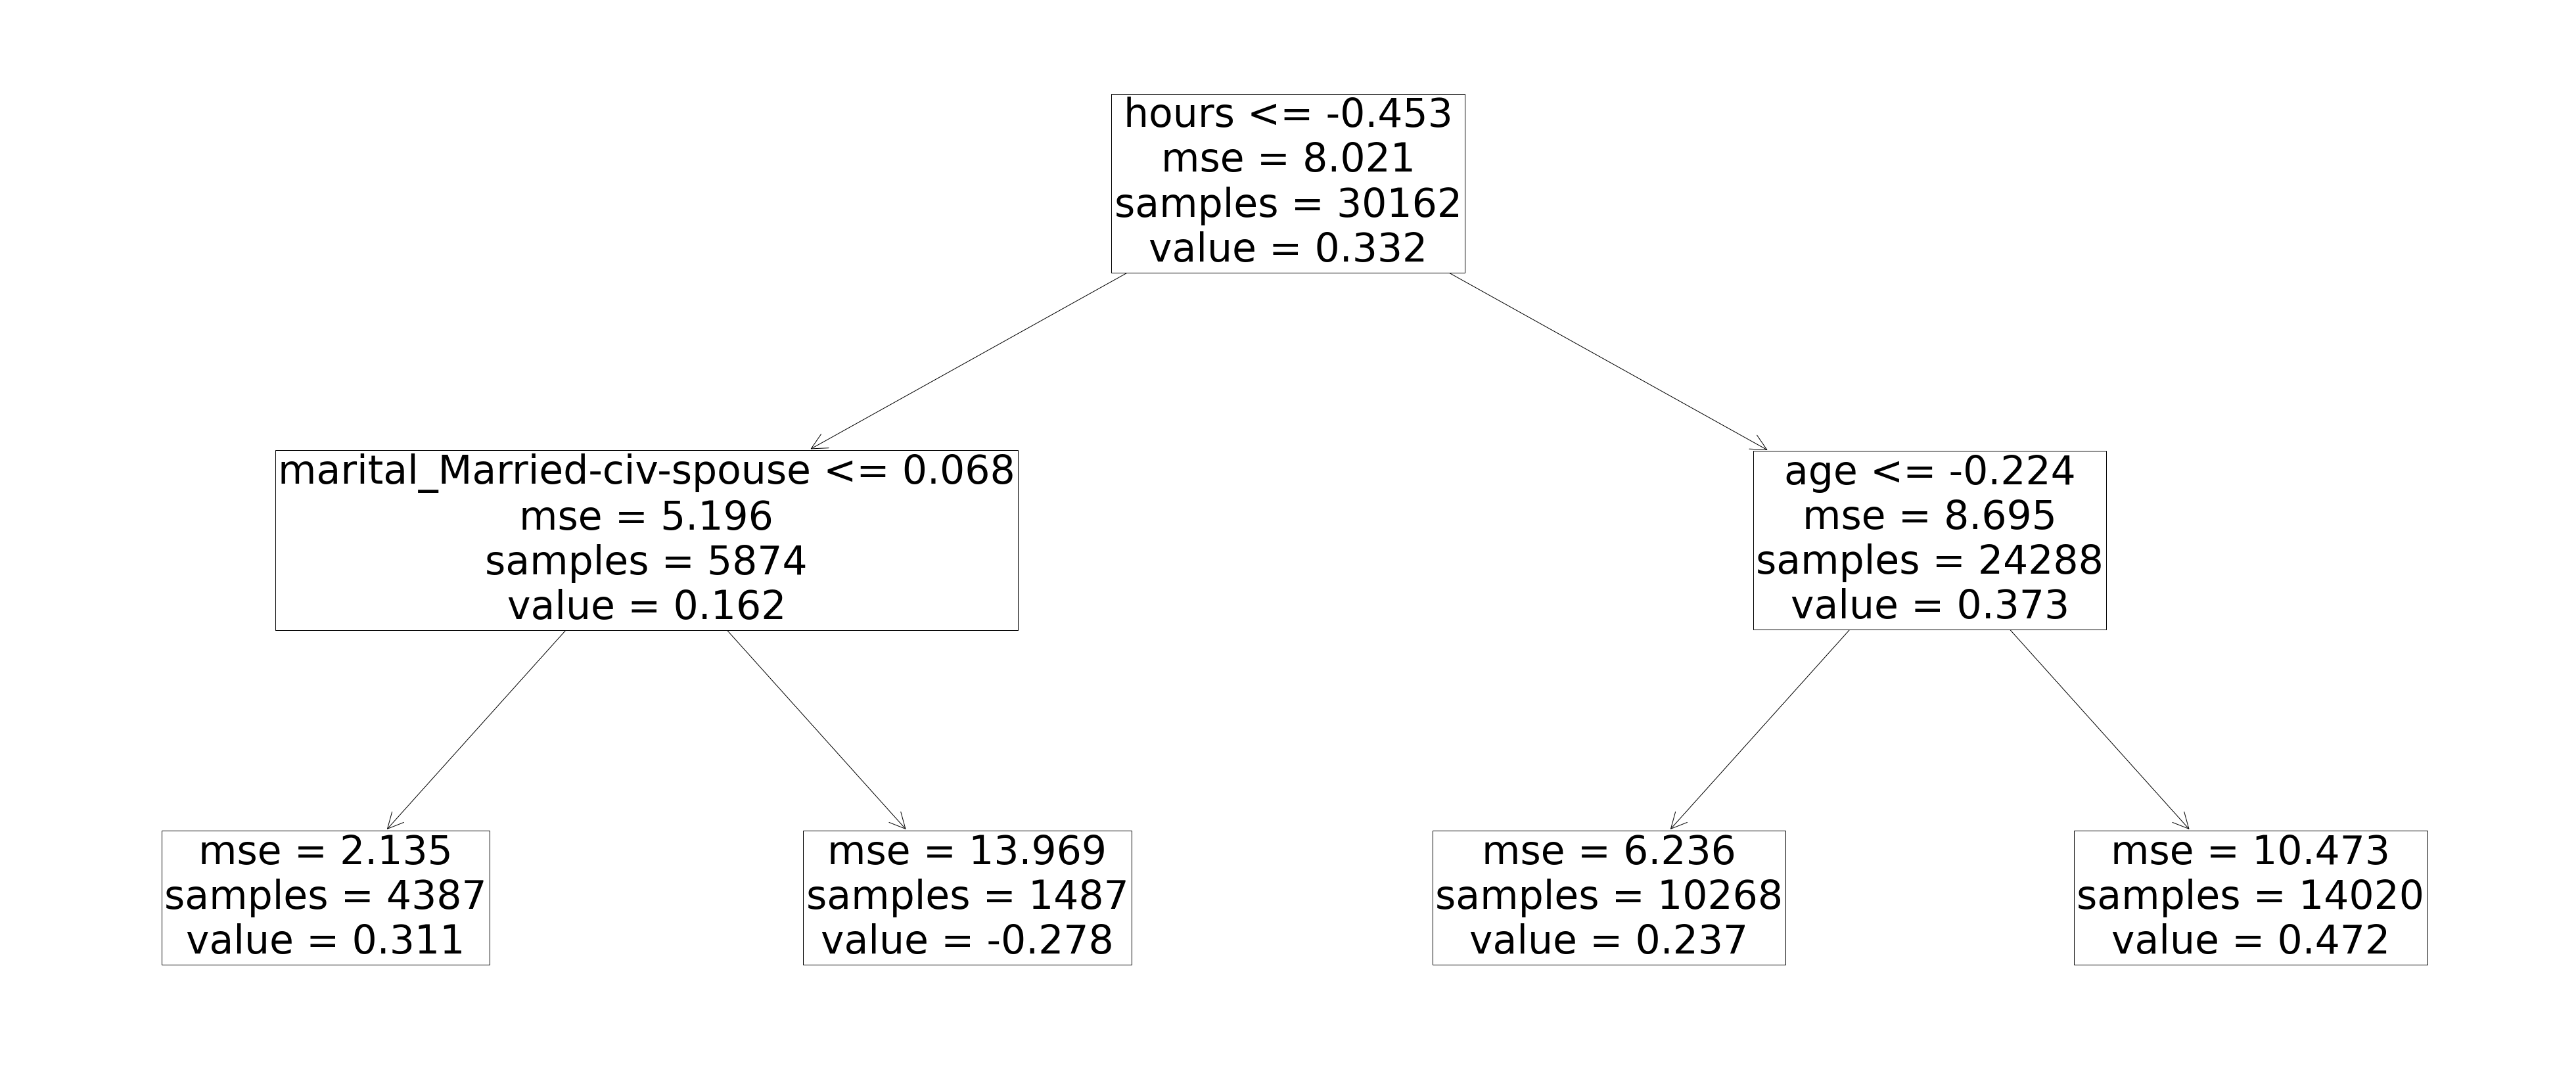

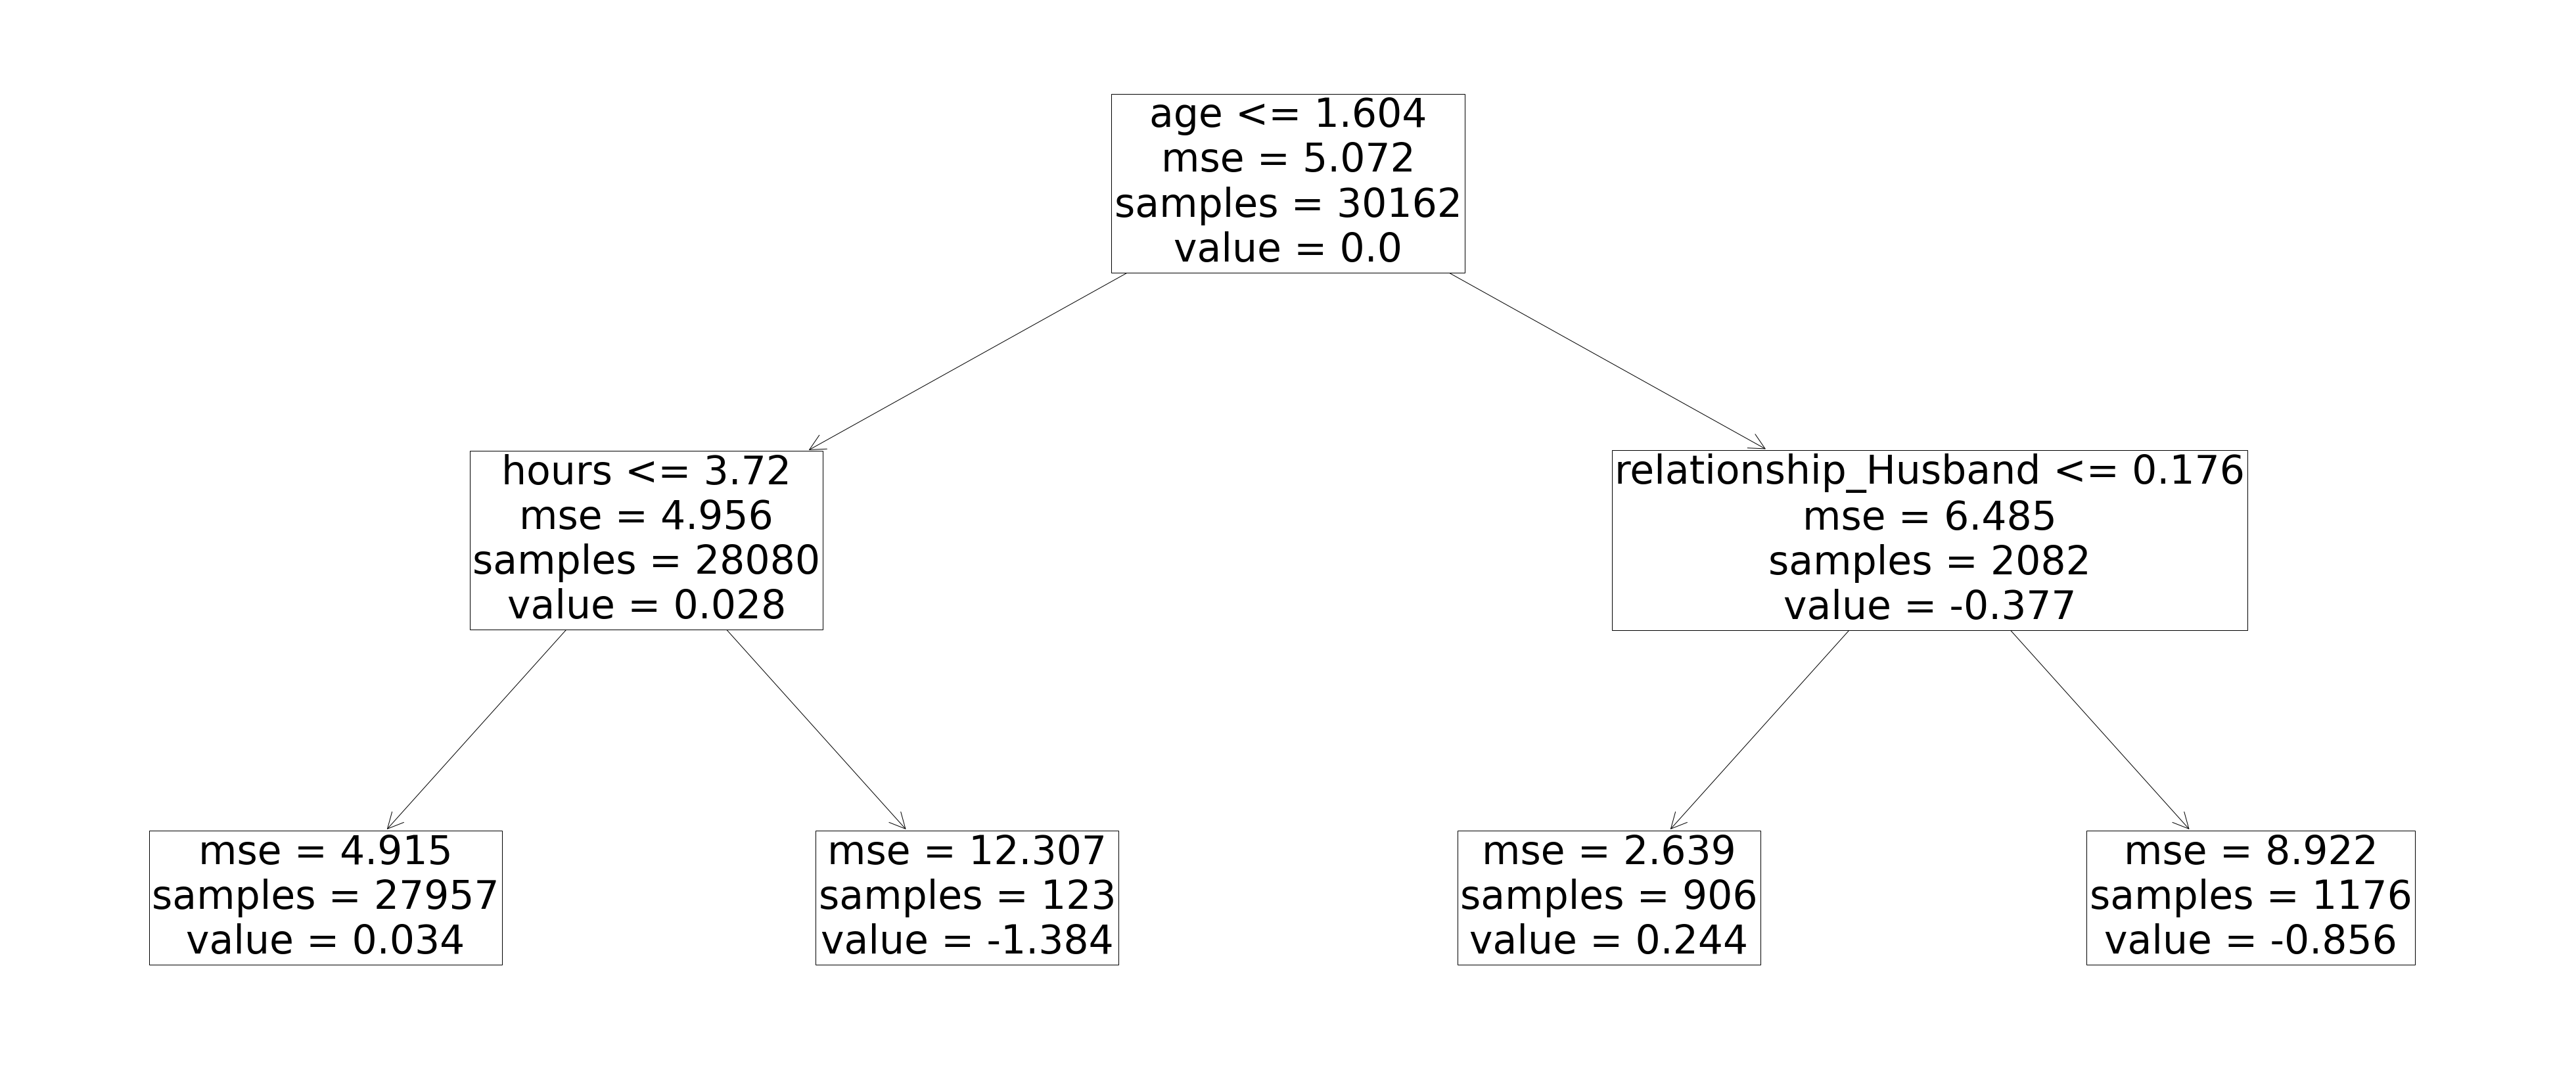

In [47]:
# Build a random forest regression model learnt on X to predict Y values
# where Y = calculated influences
# The idea is to identify attributes or predicates most important for influence computation
print("Ground truth decision tree")
norm_gt_spd = spdgt.copy()
norm_gt_spd = [float(i)*10000/sum(norm_gt_spd) for i in norm_gt_spd]
regr_2 = DecisionTreeRegressor(max_depth=2) 
regr_2.fit(X_train, norm_gt_spd)
plt.figure(figsize=(70,30))
plot_tree(regr_2, feature_names=X_train_orig.columns, fontsize=60)
# plot_tree(regr_2, fontsize=60)

print("Influence functions decision tree")
norm_infs = infs.copy()
norm_infs = [float(i)/sum(norm_infs) for i in norm_infs]
regr_1 = DecisionTreeRegressor(max_depth=2) 
regr_1.fit(X_train, norm_infs)
plt.figure(figsize=(70,30))
plot_tree(regr_1, feature_names=X_train_orig.columns, fontsize=60)

**Effect of removing top-k influential data points on SPD**

In [57]:
def top_k_influence(X_train, y_train, X_test, X_test_orig, size, infs):
    if (size==0):
        clf.fit(X_train, y_train)
    else:
        idx = sorted(range(len(infs)), key = lambda x:infs[x])[-size:] 
#         idx = random.sample(range(len(X_train)), size) #without replacement
        X_removed = np.delete(X_train, idx, 0)
        y_removed = y_train.drop(index=idx, inplace=False)
        clf.fit(X_removed, y_removed)
    y_pred = clf.predict_proba(X_test)
    spd = computeFairness(y_pred, X_test_orig)
    return spd

for i in range(100):
    size = int(len(X_train) * i/100)
#     delta_spd = (top_k_influence(X_train, y_train, X_test, X_test_orig, i, infs) - spd_0)/spd_0
    spd = (top_k_influence(X_train, y_train, X_test, X_test_orig, size, infs))
#     print('{}\t{}'.format(i, spd))

0	-0.20059371090978573
1	-0.20019896110340057
2	-0.20079805860725908
3	-0.20089537129947332
4	-0.2003245351770151
5	-0.199197101881629
6	-0.2003945898067733
7	-0.19987096655872746
8	-0.19886892180907423
9	-0.19955410806643825
10	-0.2026601953926205
11	-0.20069799065008298
12	-0.19925243413043084
13	-0.20010917105113452
14	-0.1995912969401628
15	-0.20105193972898766
16	-0.1978304536330429
17	-0.19869418148789794
18	-0.1969436525721363
19	-0.20266227216431026
20	-0.20247976513226312
21	-0.20089556078731932
22	-0.20097722417441716
23	-0.2015690302725581
24	-0.19765885674580252
25	-0.2020900570727276
26	-0.2017976129622087
27	-0.20097957033763628
28	-0.19920461175158355
29	-0.20338241133326548
30	-0.20228737565482172
31	-0.19979759149690451
32	-0.2008541448640143
33	-0.1970410515122821
34	-0.1988089368563656
35	-0.19762442035380248
36	-0.19524952107177795
37	-0.20064507728904932
38	-0.19981446527215851
39	-0.2005872506420061
40	-0.20102436114224154
41	-0.1984441160670296
42	-0.197738295457

**Decision-tree predicates**

In [64]:
predicates = ['marital_Married-civ-spouse', 'relationship_Husband', 'gender_Male']

idx = X_train_orig[(X_train_orig[predicates[0]] == 1)
#                    & (X_train_orig[predicates[1]] == 1) 
#                    & (X_train_orig[predicates[2]] == 1)
                  ].index 
X_removed = np.delete(X_train, idx, 0)
y_removed = y_train.drop(index=idx, inplace=False)
clf.fit(X_removed, y_removed)
y_pred = clf.predict_proba(X_test)
spd = computeFairness(y_pred, X_test_orig)
perc_removed = len(idx)*100/len(X_train)
print("SPD: ",spd)
print("%Rows removed: ", perc_removed)

SPD:  -0.027324387352106308
%Rows removed:  46.63152310854718


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Top-k Ground truth influence**

In [86]:
spd_gt = pd.read_csv('delta_spd_ground_truth_v0.txt', names=["Values"], sep=",")
spd_gt = spd_gt.values.tolist()
spdgt=[]
for i in range(len(spd_gt)):
    spdgt.append(spd_gt[i][0])

def gt_influence(X_train, y_train, X_test, X_test_orig, size, spd_gt):
    if (size==0):
        clf.fit(X_train, y_train)
    else:
        idx = sorted(range(len(spd_gt)), key = lambda x:spd_gt[x])[-size:] 
        X_removed = np.delete(X_train, idx, 0)
        y_removed = y_train.drop(index=idx, inplace=False)
        clf.fit(X_removed, y_removed)
    y_pred = clf.predict_proba(X_test)
    spd = computeFairness(y_pred, X_test_orig)
    return spd

for i in range(100):
    size = int(len(X_train) * i/100)
    spd = gt_influence(X_train, y_train, X_test, X_test_orig, size, spd_gt)
#     print('{}\t{}'.format(i, spd))